# Understanding VAE and ELBO through examples

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

I'll be trying to derive the VAE following the paper and other blogs
through the lens of the FashionMNIST dataset.

Our data is $X \in [0,1]^{728}$.

Let's talk about what's intractable.

We have three true distributions of the data, all represented by $p_\theta$:

1. $p_\theta(z)$ is the prior distribution of the latent variables.
2. $p_\theta(x|z)$ is the conditional distribution of the data.
3. $p_\theta(x) = \int p_\theta(z) p_\theta(x|z) dz$ The marginal distribution.



TODO: iterate points 2.1.1 and 2.1.2 about intractability

$q

In [129]:
import PIL

In [55]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

print(torch.__version__)
print(torchvision.__version__)

0.4.1
0.2.1


In [92]:
fashion_data = datasets.FashionMNIST('.', train=True, download=True,
                                    transform=transforms.ToTensor())

In [142]:
fashion_data[1][0].numpy()

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00392157, 0.        , 0.        , 0.        , 0.        ,
         0.16078432, 0.7372549 , 0.40392157, 0.21176471, 0.1882353 ,
         0.16862746, 0.34117648, 0.65882355, 0.52156866, 0.0627451 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.00392157, 0.        ,
         0.        , 0.        , 0.19215687, 0.53333336, 0.85882354,
         0.84705883, 0.89411765, 0.9254902 , 1.        , 1.        ,
         1.        , 1.        , 0.8509804 , 0.84313726, 0.99607843,
         0.90588236, 0.627451  , 0.1764706 , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.05490196, 0.6901961 , 0.87058824, 0.8784314 , 0.83137256,
         0.79607844, 0.7764706 , 0.76862746, 0.78431374, 0.84313726,
         0.

In [133]:
import PIL.Image

In [138]:
data = fashion_data[1][0].numpy().squeeze()

In [141]:
data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [139]:
PIL.Image.fromarray(data)

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=28x28 at 0x13E77E3C8>

In [136]:
PIL.Image.fromarray(fashion_data[1][0].numpy().squeeze())

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=28x28 at 0x13E77E940>

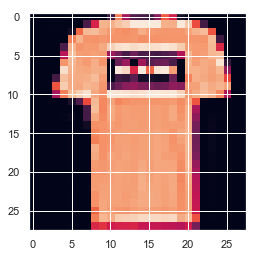

In [127]:
plt.imshow(fashion_data[1][0].numpy().squeeze())

In [106]:
data_loader = DataLoader(fashion_data, batch_size=3, shuffle=False)

In [107]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc21 = nn.Linear(100, 2)
        self.fc22 = nn.Linear(100, 2)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

In [108]:
encoder = Encoder()

In [109]:
for data, label in data_loader:
    break

In [116]:
mu, var = encoder(data.reshape(-1, 28 ** 2))

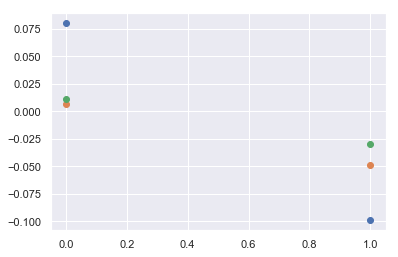

In [122]:
plt.plot(mu.data.numpy().T, 'o')

In [74]:
encoder.encode(x)

AttributeError: 'Image' object has no attribute 'dim'

In [65]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar